In [9]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral, create_pairwise_gaussian
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

H, W, NLABELS = 112, 112, 2

img = np.load('input_np.npy')
pred = np.load('output_np.npy')

index = 17  #17, 18
img_ind = img[index, :, :][:, :, np.newaxis]
pred_ind = np.tile(pred[index, :, :][np.newaxis, :, :], (2, 1, 1))
pred_ind[1, :, :] = 1 - pred_ind[0, :, :]

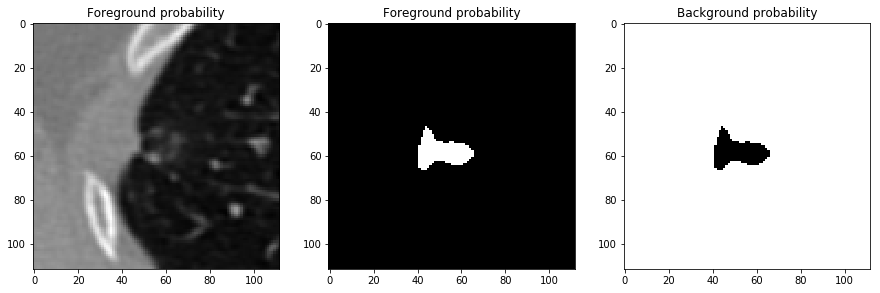

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1);
plt.imshow(img_ind[:, :, 0]);
plt.title('Foreground probability');
# plt.axis('off');
# plt.colorbar();

plt.subplot(1, 3, 2);
plt.imshow(pred_ind[0, :, :]);
plt.title('Foreground probability');
# plt.axis('off');
# plt.colorbar();

plt.subplot(1, 3, 3);
plt.imshow(pred_ind[1, :, :]);
plt.title('Background probability');
# plt.axis('off');
# plt.colorbar();

plt.show()

In [11]:
# setup the dense conditional random field for segmentation
d = dcrf.DenseCRF2D(img_ind.shape[1], img_ind.shape[0], 2)

U = unary_from_softmax(pred_ind)
# U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=HAS_UNK)
d.setUnaryEnergy(U)

pairwise_energy = create_pairwise_bilateral(sdims=(10, 10), schan=(0.01,), img=img_ind, chdim=2)
d.addPairwiseEnergy(pairwise_energy, compat=500)
d.addPairwiseGaussian(sxy=(3, 3), compat=500, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

# run iterative inference to do segmentation
Q, tmp1, tmp2 = d.startInference()
for _ in range(10):
    d.stepInference(Q, tmp1, tmp2)
map_crf1 = 1 - np.argmax(Q, axis=0).reshape((img_ind.shape[1], img_ind.shape[0]))

Q, tmp1, tmp2 = d.startInference()
for _ in range(50):
    d.stepInference(Q, tmp1, tmp2)
map_crf2 = 1 - np.argmax(Q, axis=0).reshape((img_ind.shape[1], img_ind.shape[0]))

Q, tmp1, tmp2 = d.startInference()
for _ in range(1000):
    d.stepInference(Q, tmp1, tmp2)
map_crf3 = 1 - np.argmax(Q, axis=0).reshape((img_ind.shape[1], img_ind.shape[0]))

In [12]:
if np.count_nonzero(map_crf1)==0:
    map_crf1 = pred[index, :, :]

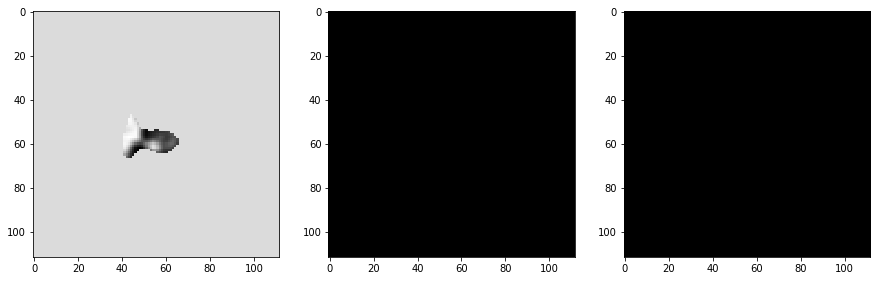

In [13]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1); plt.imshow(np.multiply(img_ind[:,:,0], map_crf1));

plt.subplot(1,3,2); plt.imshow(np.multiply(img_ind[:,:,0], map_crf2));

plt.subplot(1,3,3); plt.imshow(np.multiply(img_ind[:,:,0], map_crf3))

plt.show()

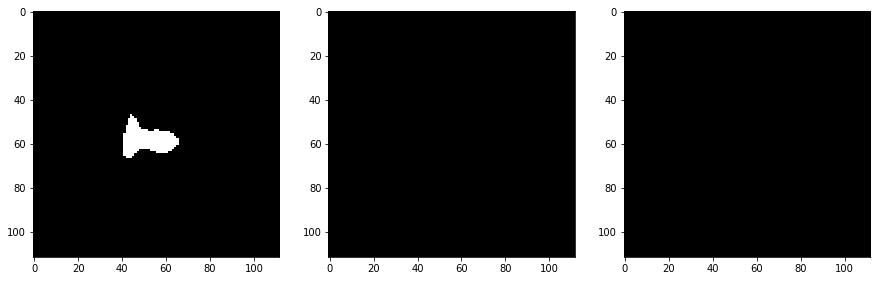

In [14]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1); plt.imshow(map_crf1);

plt.subplot(1,3,2); plt.imshow(map_crf2);

plt.subplot(1,3,3); plt.imshow(map_crf3);

plt.show()